In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import nltk

In [18]:
from konlpy.tag import Okt
from konlpy.tag import Kkma
from konlpy.utils import pprint
from konlpy.corpus import kolaw
from nltk import collocations

# http://kkma.snu.ac.kr/documents/?doc=postag << 한글 형태소 품사 태그표
# https://wikidocs.net/21698 << 자연어처리 참고 블로그
# https://konlpy.org/en/latest/api/konlpy.tag/ << okt, mecab
# https://cyc1am3n.github.io/2018/11/10/classifying_korean_movie_review.html << konlpy 로 감정분석

In [19]:
kkma = Kkma()
okt = Okt()

print(okt.pos('이 밤 그날의 반딧불을 당신의 창 가까이 보낼게요'))
print(kkma.pos('이 밤 그날의 반딧불을 당신의 창 가까이 보낼게요'))

[('이', 'Noun'), ('밤', 'Noun'), ('그날', 'Noun'), ('의', 'Josa'), ('반딧불', 'Noun'), ('을', 'Josa'), ('당신', 'Noun'), ('의', 'Josa'), ('창', 'Noun'), ('가까이', 'Noun'), ('보낼게요', 'Verb')]
[('이', 'MDT'), ('밤', 'NNG'), ('그날', 'NNG'), ('의', 'JKG'), ('반딧불', 'NNG'), ('을', 'JKO'), ('당신', 'NP'), ('의', 'JKG'), ('창', 'NNG'), ('가까이', 'MAG'), ('보내', 'VV'), ('ㄹ게요', 'EFN')]


In [4]:
import warnings

warnings.filterwarnings('ignore')

In [5]:
plt.rc('font', family='NanumGothic')
%matplotlib inline

In [6]:
law1416_df = pd.read_csv("D:/Programming/2020.11.AIcompet/law_crawling51.csv", sep=",", encoding="CP949")
law1618_df = pd.read_csv("D:/Programming/2020.11.AIcompet/law_crawling41.csv", sep=",", encoding="CP949")
law1820_df = pd.read_csv("D:/Programming/2020.11.AIcompet/law_crawling10.csv", sep=",", encoding="CP949")

In [7]:
law_df = pd.concat([law1416_df,law1618_df,law1820_df])
law_df = law_df.drop(columns='Unnamed: 0')
law_df = law_df.sort_values(by='선고일자').reset_index(drop=True)
law_df

,선고일자,법원명과 사건번호,사건명,주문,이유
0,2015.04.16,서울행정법원 [2014구합20575],난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,... 위해 거짓말을 하자 어머니와 처에게 폭행을 가하였다. 이에 원고가 화가 나 ...
1,2015.04.16,서울행정법원 [2014구합22281],난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,"..., 이하 ‘PML-N'이라고 한다) 정당원들로부터 폭행을 당하였다. 따라서 원..."
2,2015.04.16,서울행정법원 [2014구합53056],해임처분취소[행정],원고의 청구를 기각한다. 소송비용은 원고가 부담한다.,... 치료를 받게 된 것으로 이를 상해 또는 폭행으로 보기는 어렵다. 다) 제3징...
3,2015.04.16,대구지방법원 [2015가합483],손해배상(기···[민사],"1. 피고는, 가. 원고 A에게 2,000,000원 및 이에 대하여 2012. 3....",... 위와 같이 원고 A를 폭행하였다는 범죄사실로... 기소되어 성폭력... 더보...
4,2015.04.17,서울행정법원 [2014구합10677],난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,... 길에 성명불상의 4명의 남성들로부터 폭행 및 협박을 당하였다. 위 남성들을 ...
...,...,...,...,...,...
12285,2020.10.08,광주지방법원 [2020구단1349],난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,"... 하였는데, 위 가해자가 사람을 보내 원고를 폭행하고 신고를 취하하라고 협박하..."
12286,2020.10.14,대구지방법원 김천지원 [2019가단34875],명의이전등록···[민사],"1. 피고는 원고에게, 가. 별지 목록 기재 자동차에 관하여 구미시 차량등록사업소 ...","... 항의하였고 이로 인하여 피고로부터 폭행을 당하였다고 진술하였으며, 이 사건...."
12287,2020.10.14,제주지방법원 [2019나15489],손해배상(기···[민사],"1. 당심에서 확장된 원고의 청구에 따라 제1심판결의 주문 제1, 2항을 다음과 같...","... 한 사실이 인정되고, 이러한 사정이 피고의 폭행을 유발하였다고 보인다. 이와..."
12288,2020.10.14,청주지방법원 [2020가단25635],급여지급[민사],"피고는 원고에게 58,580,000원과 이에 대한 2019. 2. 14.부터 202...","... 학생들을 상대로 실시된 학교폭력(성폭력) 피해에 대한 설문조사 결과, ‘어깨..."


In [8]:
# 승소여부를 판단할 수 있는 주문 feature에는 '기각','각하' 등등 패소 여부를 알 수 있는 단어들이 있다.
# 우선 '기각','각하'를 기준으로 승소 여부를 판단

temp1 = law_df['주문']
temp2 = []
for morp in temp1:
    if ('기각' in morp) or ('각하' in morp):
        temp2.append(0)
    else:
        temp2.append(1)

print(temp2[:10])
print(len(temp2))

[0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
12290


In [9]:
law_df['승소여부'] = temp2
law_df.head()

,선고일자,법원명과 사건번호,사건명,주문,이유,승소여부
0,2015.04.16,서울행정법원 [2014구합20575],난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,... 위해 거짓말을 하자 어머니와 처에게 폭행을 가하였다. 이에 원고가 화가 나 ...,0
1,2015.04.16,서울행정법원 [2014구합22281],난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,"..., 이하 ‘PML-N'이라고 한다) 정당원들로부터 폭행을 당하였다. 따라서 원...",0
2,2015.04.16,서울행정법원 [2014구합53056],해임처분취소[행정],원고의 청구를 기각한다. 소송비용은 원고가 부담한다.,... 치료를 받게 된 것으로 이를 상해 또는 폭행으로 보기는 어렵다. 다) 제3징...,0
3,2015.04.16,대구지방법원 [2015가합483],손해배상(기···[민사],"1. 피고는, 가. 원고 A에게 2,000,000원 및 이에 대하여 2012. 3....",... 위와 같이 원고 A를 폭행하였다는 범죄사실로... 기소되어 성폭력... 더보...,1
4,2015.04.17,서울행정법원 [2014구합10677],난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,... 길에 성명불상의 4명의 남성들로부터 폭행 및 협박을 당하였다. 위 남성들을 ...,0


In [10]:
law_name = law_df['법원명과 사건번호']
law_name2 = []
law_name3 = []

for i in law_name:
    law_name2.append(i.split())

for i in law_name2:
    law_name3.append(i[0])

law_df['법원명과 사건번호'] = law_name3
law_df.rename(columns={'법원명과 사건번호':'법원명'}, inplace=True)

In [11]:
law_df

,선고일자,법원명,사건명,주문,이유,승소여부
0,2015.04.16,서울행정법원,난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,... 위해 거짓말을 하자 어머니와 처에게 폭행을 가하였다. 이에 원고가 화가 나 ...,0
1,2015.04.16,서울행정법원,난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,"..., 이하 ‘PML-N'이라고 한다) 정당원들로부터 폭행을 당하였다. 따라서 원...",0
2,2015.04.16,서울행정법원,해임처분취소[행정],원고의 청구를 기각한다. 소송비용은 원고가 부담한다.,... 치료를 받게 된 것으로 이를 상해 또는 폭행으로 보기는 어렵다. 다) 제3징...,0
3,2015.04.16,대구지방법원,손해배상(기···[민사],"1. 피고는, 가. 원고 A에게 2,000,000원 및 이에 대하여 2012. 3....",... 위와 같이 원고 A를 폭행하였다는 범죄사실로... 기소되어 성폭력... 더보...,1
4,2015.04.17,서울행정법원,난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,... 길에 성명불상의 4명의 남성들로부터 폭행 및 협박을 당하였다. 위 남성들을 ...,0
...,...,...,...,...,...,...
12285,2020.10.08,광주지방법원,난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,"... 하였는데, 위 가해자가 사람을 보내 원고를 폭행하고 신고를 취하하라고 협박하...",0
12286,2020.10.14,대구지방법원,명의이전등록···[민사],"1. 피고는 원고에게, 가. 별지 목록 기재 자동차에 관하여 구미시 차량등록사업소 ...","... 항의하였고 이로 인하여 피고로부터 폭행을 당하였다고 진술하였으며, 이 사건....",1
12287,2020.10.14,제주지방법원,손해배상(기···[민사],"1. 당심에서 확장된 원고의 청구에 따라 제1심판결의 주문 제1, 2항을 다음과 같...","... 한 사실이 인정되고, 이러한 사정이 피고의 폭행을 유발하였다고 보인다. 이와...",1
12288,2020.10.14,청주지방법원,급여지급[민사],"피고는 원고에게 58,580,000원과 이에 대한 2019. 2. 14.부터 202...","... 학생들을 상대로 실시된 학교폭력(성폭력) 피해에 대한 설문조사 결과, ‘어깨...",1


In [14]:
law_name_cd = law_df['법원명'].unique()
law_name_cd = {string:i for i,string in enumerate(law_name_cd)}
law_name_cd

{'서울행정법원': 0,
 '대구지방법원': 1,
 '서울고등법원': 2,
 '광주지방법원': 3,
 '서울중앙지방법원': 4,
 '부산지방법원': 5,
 '인천지방법원': 6,
 '울산지방법원': 7,
 '제주지방법원': 8,
 '대전고등법원': 9,
 '춘천지방법원': 10,
 '창원지방법원': 11,
 '서울동부지방법원': 12,
 '의정부지방법원': 13,
 '수원지방법원': 14,
 '대전지방법원': 15,
 '광주고등법원': 16,
 '부산고등법원': 17,
 '전주지방법원': 18,
 '서울남부지방법원': 19,
 '청주지방법원': 20,
 '서울북부지방법원': 21,
 '서울서부지방법원': 22,
 '대법원': 23,
 '대구고등법원': 24,
 '수원고등법원': 25,
 '특허법원': 26}

In [15]:
law_df['법원명'].replace(law_name_cd, inplace=True)

In [16]:
law_df.head()

,선고일자,법원명,사건명,주문,이유,승소여부
0,2015.04.16,0,난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,... 위해 거짓말을 하자 어머니와 처에게 폭행을 가하였다. 이에 원고가 화가 나 ...,0
1,2015.04.16,0,난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,"..., 이하 ‘PML-N'이라고 한다) 정당원들로부터 폭행을 당하였다. 따라서 원...",0
2,2015.04.16,0,해임처분취소[행정],원고의 청구를 기각한다. 소송비용은 원고가 부담한다.,... 치료를 받게 된 것으로 이를 상해 또는 폭행으로 보기는 어렵다. 다) 제3징...,0
3,2015.04.16,1,손해배상(기···[민사],"1. 피고는, 가. 원고 A에게 2,000,000원 및 이에 대하여 2012. 3....",... 위와 같이 원고 A를 폭행하였다는 범죄사실로... 기소되어 성폭력... 더보...,1
4,2015.04.17,0,난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,... 길에 성명불상의 4명의 남성들로부터 폭행 및 협박을 당하였다. 위 남성들을 ...,0


In [20]:
temp1 = law_df['이유']
temp2 = []
for i in temp1:
    temp2.append(okt.pos(i))

temp2[:10]

# okt.pos 사용해 형태소로 분할

[[('...', 'Punctuation'),
  ('위해', 'Noun'),
  ('거짓말', 'Noun'),
  ('을', 'Josa'),
  ('하자', 'Noun'),
  ('어머니', 'Noun'),
  ('와', 'Josa'),
  ('처', 'Noun'),
  ('에게', 'Josa'),
  ('폭행', 'Noun'),
  ('을', 'Josa'),
  ('가하였다', 'Verb'),
  ('.', 'Punctuation'),
  ('이', 'Noun'),
  ('에', 'Josa'),
  ('원고', 'Noun'),
  ('가', 'Josa'),
  ('화가', 'Noun'),
  ('나', 'Noun'),
  ('칼', 'Noun'),
  ('을', 'Josa'),
  ('...', 'Punctuation'),
  ('더', 'Noun'),
  ('보기', 'Noun'),
  ('...', 'Punctuation'),
  ('이유', 'Noun'),
  ('로', 'Josa'),
  ('카메룬', 'Noun'),
  ('경찰', 'Noun'),
  ('에', 'Josa'),
  ('의해', 'Adjective'),
  ('구속', 'Noun'),
  ('되었다', 'Verb'),
  ('.', 'Punctuation'),
  ('원고', 'Noun'),
  ('는', 'Josa'),
  ('삼촌', 'Noun'),
  ('의', 'Josa'),
  ('부탁', 'Noun'),
  ('으로', 'Josa'),
  ('삼촌', 'Noun'),
  ('집', 'Noun'),
  ('에', 'Josa'),
  ('있던', 'Adjective'),
  ('반정부', 'Noun'),
  ('성향', 'Noun'),
  ('의', 'Josa'),
  ('책자', 'Noun'),
  ('를', 'Josa'),
  ('자신', 'Noun'),
  ('의', 'Josa'),
  ('집', 'Noun'),
  ('에', 'Josa'),
  ('숨겼는데', 'Ver

In [21]:
law_df['이유토큰화'] = temp2
law_df.head()

,선고일자,법원명,사건명,주문,이유,승소여부,이유토큰화
0,2015.04.16,0,난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,... 위해 거짓말을 하자 어머니와 처에게 폭행을 가하였다. 이에 원고가 화가 나 ...,0,"[(..., Punctuation), (위해, Noun), (거짓말, Noun), ..."
1,2015.04.16,0,난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,"..., 이하 ‘PML-N'이라고 한다) 정당원들로부터 폭행을 당하였다. 따라서 원...",0,"[(...,, Punctuation), (이하, Noun), (‘, Foreign)..."
2,2015.04.16,0,해임처분취소[행정],원고의 청구를 기각한다. 소송비용은 원고가 부담한다.,... 치료를 받게 된 것으로 이를 상해 또는 폭행으로 보기는 어렵다. 다) 제3징...,0,"[(..., Punctuation), (치료, Noun), (를, Josa), (받..."
3,2015.04.16,1,손해배상(기···[민사],"1. 피고는, 가. 원고 A에게 2,000,000원 및 이에 대하여 2012. 3....",... 위와 같이 원고 A를 폭행하였다는 범죄사실로... 기소되어 성폭력... 더보...,1,"[(..., Punctuation), (위, Noun), (와, Josa), (같이..."
4,2015.04.17,0,난민불인정결···[행정],1. 원고의 청구를 기각한다. 2. 소송비용은 원고가 부담한다.,... 길에 성명불상의 4명의 남성들로부터 폭행 및 협박을 당하였다. 위 남성들을 ...,0,"[(..., Punctuation), (길, Noun), (에, Josa), (성명..."


In [22]:
law_df.to_csv('law_preprocessing2.csv', sep=',', na_rep='NaN', encoding='CP949')

# -------------------전처리 완료! // 이제 모델링 및 모델 학습 시작 --------

In [23]:
tokens = [t for d in temp2 for t in d]
print(len(tokens))

5028837


In [24]:
text = nltk.Text(tokens, name='NMSC')

print(len(text.tokens)) # 전체 토큰의 개수
print(len(set(text.tokens))) # 중복 제외한 토큰의 개수
pprint(text.vocab().most_common(10)) # 출현 빈도가 높은 상위 토큰 10개

5028837
52909
[(('.', 'Punctuation'), 243249),
 ((',', 'Punctuation'), 163386),
 (('의', 'Josa'), 132192),
 (('을', 'Josa'), 119155),
 (('에', 'Josa'), 106467),
 (('원고', 'Noun'), 102568),
 (('를', 'Josa'), 76715),
 (('이', 'Noun'), 56445),
 (('피고', 'Noun'), 54592),
 (('가', 'Josa'), 54394)]


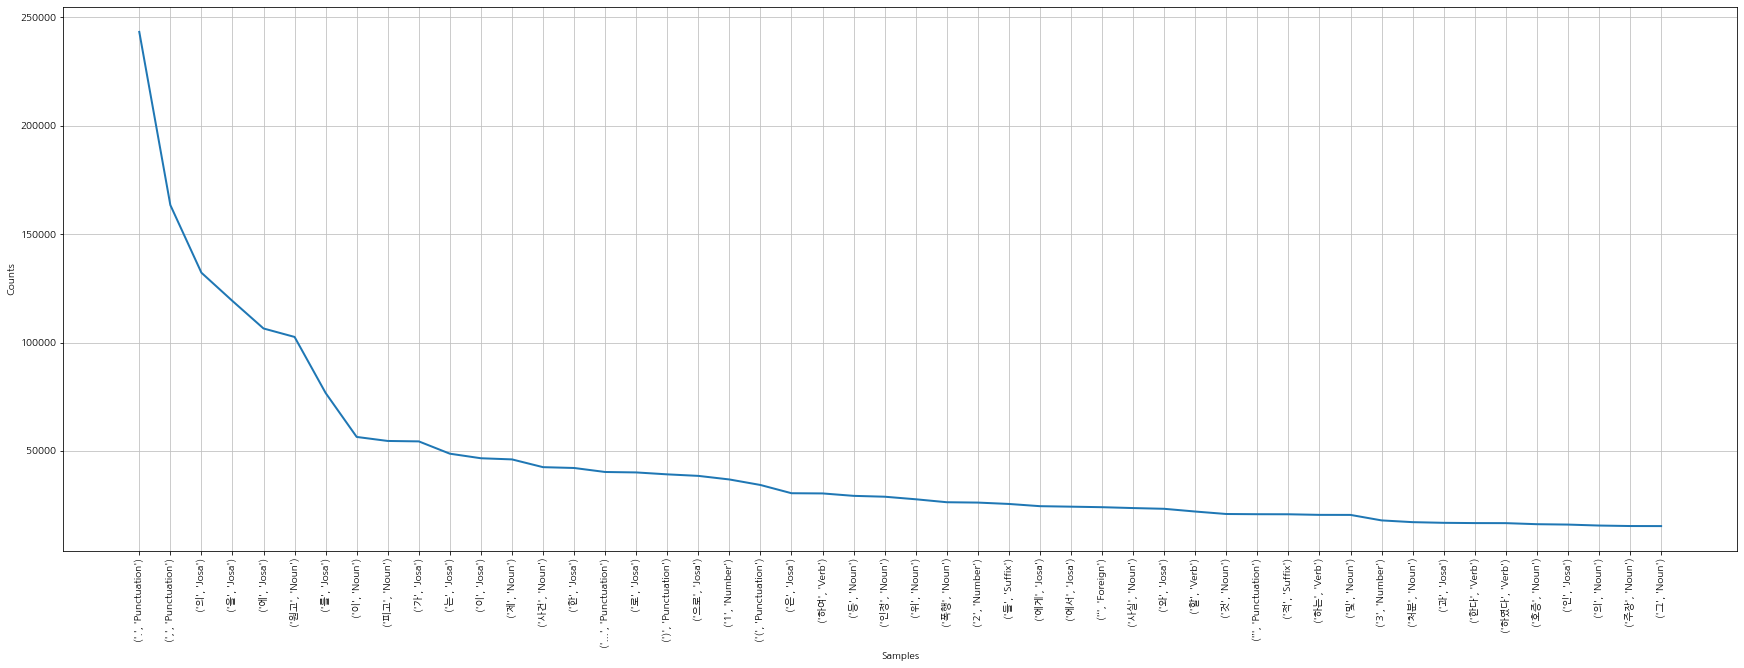

In [25]:
plt.figure(figsize=(30,10))
text.plot(50)

In [26]:
X_data = law_df['이유토큰화']
y_data = law_df['승소여부']

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9217,), (3073,), (9217,), (3073,))

In [28]:
selected_words = [f[0] for f in text.vocab().most_common(1000)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d in X_train]
test_x = [term_frequency(d) for d in X_test]
train_y = [c for c in y_train]
test_y = [c for c in y_test]

In [29]:
len(train_x[0])

1000

In [30]:
XX_train = np.asarray(train_x).astype('float32')
XX_test = np.asarray(test_x).astype('float32')

yy_train = np.asarray(train_y).astype('float32')
yy_test = np.asarray(test_y).astype('float32')

In [31]:
XX_train.shape, XX_test.shape, yy_train.shape, yy_test.shape

((9217, 1000), (3073, 1000), (9217,), (3073,))

In [32]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [33]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model.fit(XX_train, yy_train, epochs=10, batch_size=512)
results = model.evaluate(XX_test, yy_test)

Epoch 1/10
19/19 [==============================] - 0s 9ms/step - loss: 0.5687 - binary_accuracy: 0.6859
Epoch 2/10
19/19 [==============================] - 1s 37ms/step - loss: 0.4730 - binary_accuracy: 0.7527
Epoch 3/10
19/19 [==============================] - 0s 5ms/step - loss: 0.4388 - binary_accuracy: 0.7794
Epoch 4/10
19/19 [==============================] - 0s 5ms/step - loss: 0.4090 - binary_accuracy: 0.8031
Epoch 5/10
19/19 [==============================] - 0s 5ms/step - loss: 0.3932 - binary_accuracy: 0.8094
Epoch 6/10
19/19 [==============================] - 0s 5ms/step - loss: 0.3533 - binary_accuracy: 0.8444
Epoch 7/10
19/19 [==============================] - 0s 5ms/step - loss: 0.3473 - binary_accuracy: 0.8457
Epoch 8/10
19/19 [==============================] - 0s 5ms/step - loss: 0.3176 - binary_accuracy: 0.8636
Epoch 9/10
19/19 [==============================] - 0s 5ms/step - loss: 0.3026 - binary_accuracy: 0.8715
Epoch 10/10
97/97 [==============================] - 0

In [34]:
results

[0.49422261118888855, 0.7650504112243652]

------------------ 이제 아예 새로운 데이터(고객에게 받은 글) 받을 때 정확도 나타내는 것 ----------------

In [35]:
def tokenize(writing):
    return ['/'.join(t) for t in okt.pos(writing, norm=True, stem=True)]

In [39]:
def predict_pos_neg(review):

    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        print("[{}]는 {:.2f}% 확률로 승소이지 않을까 추측해봅니다.^^\n".format(review, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 패소이지 않을까 추측해봅니다.^^;\n".format(review, (1 - score) * 100))

In [40]:
predict_pos_neg('올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.')

[올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.]는 52.15% 확률로 승소이지 않을까 추측해봅니다.^^



In [41]:
predict_pos_neg('기복과 근거 없는 부정행위 의심, 폭언, 폭행을 주장한 사실이 인정된다. 그러나, 피고는 원고에게 불법행위에 기한 손해배상으로 위자료 1,700만 원 및 이에 대하여 이 사건 소장 부본 송달 다음날인 2019. 11. 7.부터(원고는 불법행위의 시기인 2019. 9. 10.부터 지연손해금의 지급을 구한다고 주장하나, 원고의 청구는 부정행위 기간 전체에 대한 위자료 청구이고, 종기에 대한 주장, 입증이 없으므로, 이 사건 소장 부본 송달 다음날부터 지연손해금의 지급을 명한다) 이 판결 선고일인 2020. 10. 7.까지는 민법이 정한 연 5%, 그 다음날부터 다 갚는 날까지는 소송촉진 등에 관한 특례법이 정한 연 12%의 각 비율로 계산한 지연손해금을 지급할 의무가 있다. 3. 피고의 주장에 대한 판단 가. 주장의 요지 C와 원고의 혼인관계는 2019. 8.경부터 파탄 상태였다. 따라서, 피고와 C의 행위가 원고의 부부공동생활을 침해하거나 유지를 방해하였다고 할 수 없다. 나. 판단 을 제7호증, 갑 제11호증, 변론 전체의 취지를 종합하면, C가 2019. 10. 30. 인천가정법원 2019너16027호(2019드단115082호로 접수되었다가 재배당되었다)로 원고에 대하여 이혼 및 위자료 2,000만 원 지급을 구하는 조정신청을 한 사실, C는 신청원인으로 원고의 감정 기복과 근거 없는 부정행위 의심, 폭언, 폭행을 주장한 사실이 인정된다. 그러나, 위와 같은 사정만으로는 피고와 C의 부정행위 당시 이미 원고와 C의 부부공동생활이 실질적으로 파탄되어 실체가 더 이상 존재하지 아니하게 되고 객관적으로 회복할 수 없는 정도에 이르렀다고 보기에 부족하고 달리 이를 인정할 증거가 없다. 따라서, 피고의 주장은 이유 없다. 4. 결론 원고의 청구는 위 인정범위 내에서 이유 있으므로 이를 인용하고, 나머지 청구는 이유 없으므로 이를 기각하기로 하여 주문과 같이 판결한다')

[기복과 근거 없는 부정행위 의심, 폭언, 폭행을 주장한 사실이 인정된다. 그러나, 위와... 더보기 ... 따라서 피고는 원고에게 불법행위에 기한 손해배상으로 위자료 1,700만 원 및 이에 대하여 이 사건 소장 부본 송달 다음날인 2019. 11. 7.부터(원고는 불법행위의 시기인 2019. 9. 10.부터 지연손해금의 지급을 구한다고 주장하나, 원고의 청구는 부정행위 기간 전체에 대한 위자료 청구이고, 종기에 대한 주장, 입증이 없으므로, 이 사건 소장 부본 송달 다음날부터 지연손해금의 지급을 명한다) 이 판결 선고일인 2020. 10. 7.까지는 민법이 정한 연 5%, 그 다음날부터 다 갚는 날까지는 소송촉진 등에 관한 특례법이 정한 연 12%의 각 비율로 계산한 지연손해금을 지급할 의무가 있다. 3. 피고의 주장에 대한 판단 가. 주장의 요지 C와 원고의 혼인관계는 2019. 8.경부터 파탄 상태였다. 따라서, 피고와 C의 행위가 원고의 부부공동생활을 침해하거나 유지를 방해하였다고 할 수 없다. 나. 판단 을 제7호증, 갑 제11호증, 변론 전체의 취지를 종합하면, C가 2019. 10. 30. 인천가정법원 2019너16027호(2019드단115082호로 접수되었다가 재배당되었다)로 원고에 대하여 이혼 및 위자료 2,000만 원 지급을 구하는 조정신청을 한 사실, C는 신청원인으로 원고의 감정 기복과 근거 없는 부정행위 의심, 폭언, 폭행을 주장한 사실이 인정된다. 그러나, 위와 같은 사정만으로는 피고와 C의 부정행위 당시 이미 원고와 C의 부부공동생활이 실질적으로 파탄되어 실체가 더 이상 존재하지 아니하게 되고 객관적으로 회복할 수 없는 정도에 이르렀다고 보기에 부족하고 달리 이를 인정할 증거가 없다. 따라서, 피고의 주장은 이유 없다. 4. 결론 원고의 청구는 위 인정범위 내에서 이유 있으므로 이를 인용하고, 나머지 청구는 이유 없으므로 이를 기각하기로 하여 주문과 같이 판결한다]는 52.15% 확률로 승소이지 않을까 추측해봅니다.^^



In [42]:
law_df['이유'].loc[10]

'... 따르면, 원고는 다음과 같이 B로부터 폭행당한 경위를 설명하고 있다. “술에 취한 B가... 더보기 ... 있다고 보아야 한다. 나. 관계법령 산업재해보상보험법 제5조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. 1. “업무상의 재해”란 업무상의 사유에 따른 근로자의 부상질병장해 또는 사망을 말한다. 제49조(추가상병 요양급여의 신청) 업무상의 재해로 요양 중인 근로자는 다음 각 호의 어느 하나에 해당하는 경우에는 그 부상 또는 질병(이하, “추가상병”이라 한다.)에 대한 요양급여를 신청할 수 있다. 1. 그 업무상의 재해로 이미 발생한 부상이나 질병이 추가로 발견되어 요양이 필요한 경우 2. 그 업무상의 재해로 발생한 부상이나 질병이 원인이 되어 새로운 질병이 발생하여 요양이 필요한 경우 다. 인정사실 (1) 이 사건 재해의 내용에 관한 원고의 진술 2012. 2. 17.자 피고 담당공무원 작성의 문답서(갑 제5호증)에 따르면, 원고는 다음과 같이 B로부터 폭행당한 경위를 설명하고 있다. “술에 취한 B가 원고의 목부위에 휴대전화기를 던졌고, 오른손으로 턱을 가격하였다. 주변에서 사람들이 말려서 분을 삭이기 위하여 의자에 앉아 있었는데, B가 다가와 쓰레기통 뚜껑으로 원고를 때렸다. 이후 발인지 손인지 잘 모르겠으나 등을 맞았고, 의자에서 떨어져 땅바닥에 주저앉아 있을 때 발로도 밟힌 것 같다. B로부터 맞은 부위는 목, 오른쪽 턱, 등, 허리 쪽이다. 예전에 허리부위에 수술을 2번 받은 적이 있는데 이 사건 이후 병원에 가 보았더니 옛날 수술부위는 괜찮은데 그 윗부분에 이상이 생겼다고 하였다.” (2) 원고의 이 사건 재해 이전의 치료내역 원고는 2001. 6.경부터 요추부통증 및 제4-5요추-제1천추간 퇴행성 병변으로 의료기관에서 진료를 받기 시작하였고, 2009. 1.경부터 2010. 10.경까지 사이에는 7회에 걸쳐...'

In [43]:
predict_pos_neg('따르면, 원고는 다음과 같이 B로부터 폭행당한 경위를 설명하고 있다. “술에 취한 B가... 더보기 ... 있다고 보아야 한다. 나. 관계법령 산업재해보상보험법 제5조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. 1. “업무상의 재해”란 업무상의 사유에 따른 근로자의 부상질병장해 또는 사망을 말한다. 제49조(추가상병 요양급여의 신청) 업무상의 재해로 요양 중인 근로자는 다음 각 호의 어느 하나에 해당하는 경우에는 그 부상 또는 질병(이하, “추가상병”이라 한다.)에 대한 요양급여를 신청할 수 있다. 1. 그 업무상의 재해로 이미 발생한 부상이나 질병이 추가로 발견되어 요양이 필요한 경우 2. 그 업무상의 재해로 발생한 부상이나 질병이 원인이 되어 새로운 질병이 발생하여 요양이 필요한 경우 다. 인정사실 (1) 이 사건 재해의 내용에 관한 원고의 진술 2012. 2. 17.자 피고 담당공무원 작성의 문답서(갑 제5호증)에 따르면, 원고는 다음과 같이 B로부터 폭행당한 경위를 설명하고 있다. “술에 취한 B가 원고의 목부위에 휴대전화기를 던졌고, 오른손으로 턱을 가격하였다. 주변에서 사람들이 말려서 분을 삭이기 위하여 의자에 앉아 있었는데, B가 다가와 쓰레기통 뚜껑으로 원고를 때렸다. 이후 발인지 손인지 잘 모르겠으나 등을 맞았고, 의자에서 떨어져 땅바닥에 주저앉아 있을 때 발로도 밟힌 것 같다. B로부터 맞은 부위는 목, 오른쪽 턱, 등, 허리 쪽이다. 예전에 허리부위에 수술을 2번 받은 적이 있는데 이 사건 이후 병원에 가 보았더니 옛날 수술부위는 괜찮은데 그 윗부분에 이상이 생겼다고 하였다.” (2) 원고의 이 사건 재해 이전의 치료내역 원고는 2001. 6.경부터 요추부통증 및 제4-5요추-제1천추간 퇴행성 병변으로 의료기관에서 진료를 받기 시작하였고, 2009. 1.경부터 2010. 10.경까지 사이에는 7회에 걸쳐')

[따르면, 원고는 다음과 같이 B로부터 폭행당한 경위를 설명하고 있다. “술에 취한 B가... 더보기 ... 있다고 보아야 한다. 나. 관계법령 산업재해보상보험법 제5조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. 1. “업무상의 재해”란 업무상의 사유에 따른 근로자의 부상질병장해 또는 사망을 말한다. 제49조(추가상병 요양급여의 신청) 업무상의 재해로 요양 중인 근로자는 다음 각 호의 어느 하나에 해당하는 경우에는 그 부상 또는 질병(이하, “추가상병”이라 한다.)에 대한 요양급여를 신청할 수 있다. 1. 그 업무상의 재해로 이미 발생한 부상이나 질병이 추가로 발견되어 요양이 필요한 경우 2. 그 업무상의 재해로 발생한 부상이나 질병이 원인이 되어 새로운 질병이 발생하여 요양이 필요한 경우 다. 인정사실 (1) 이 사건 재해의 내용에 관한 원고의 진술 2012. 2. 17.자 피고 담당공무원 작성의 문답서(갑 제5호증)에 따르면, 원고는 다음과 같이 B로부터 폭행당한 경위를 설명하고 있다. “술에 취한 B가 원고의 목부위에 휴대전화기를 던졌고, 오른손으로 턱을 가격하였다. 주변에서 사람들이 말려서 분을 삭이기 위하여 의자에 앉아 있었는데, B가 다가와 쓰레기통 뚜껑으로 원고를 때렸다. 이후 발인지 손인지 잘 모르겠으나 등을 맞았고, 의자에서 떨어져 땅바닥에 주저앉아 있을 때 발로도 밟힌 것 같다. B로부터 맞은 부위는 목, 오른쪽 턱, 등, 허리 쪽이다. 예전에 허리부위에 수술을 2번 받은 적이 있는데 이 사건 이후 병원에 가 보았더니 옛날 수술부위는 괜찮은데 그 윗부분에 이상이 생겼다고 하였다.” (2) 원고의 이 사건 재해 이전의 치료내역 원고는 2001. 6.경부터 요추부통증 및 제4-5요추-제1천추간 퇴행성 병변으로 의료기관에서 진료를 받기 시작하였고, 2009. 1.경부터 2010. 10.경까지 사이에는 7회에 걸쳐]는 52.15% 확률로 승소이지 않을까 추측해봅니다.^^

